In [96]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [251]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from openquake.hazardlib.imt import IMT, SA, PGA, AvgSA
from openquake.hazardlib.gsim.base import GMPE
from openquake.hazardlib.gsim.bchydro_2016_epistemic import BCHydroESHM20SSlab
from openquake.hazardlib.gsim.bahrampouri_2021_duration import BahrampouriEtAldm2021SSlab, BahrampouriEtAldm2021Asc
from openquake.hazardlib.gsim.kotha_2020 import KothaEtAl2020ESHM20
from openquake.hazardlib.gsim.mgmpe.generic_gmpe_avgsa import BakerJayaramCorrelationModel, ESHM20CorrelationModel

import pickagm.eqdbases as eqdb
import pickagm.dfops as dfops
from pickagm.interpolate import interpolate, interpolate_SA_df
import pickagm.avgSA
from phd_project.config.loader import load_config
from phd_project.scripts.WP1_ground_motion_set.correlations import (
    derive_correlation_model
    )

cfg = load_config()

In [159]:
# load a flatfile
db_fp = cfg["data"]["gm_flatfiles"] / "active_shallow_crust_esm_flatfile.csv"
df = pd.read_csv(db_fp, sep=";", index_col=0, 
                 dtype={
                     "Ms_ref": str,
                     "EMEC_Mw_type": str,
                     "EMEC_Mw_ref": str,
                     "location_code": str
                    })
df.head()

,event_id,event_time,ISC_ev_id,USGS_ev_id,INGV_ev_id,EMSC_ev_id,ev_nation_code,ev_latitude,ev_longitude,ev_depth_km,...,rotD00_T3_000,rotD00_T3_500,rotD00_T4_000,rotD00_T4_500,rotD00_T5_000,rotD00_T6_000,rotD00_T7_000,rotD00_T8_000,rotD00_T9_000,rotD00_T10_000
0,AL-2014-0005,2014-01-20 14:40:48,NaN,usb000m4t2,NaN,NaN,AL,41.2985,19.4484,28.26,...,0.012796,0.010137,0.008776,0.006618,0.003835,0.002287,0.001832,0.001362,0.001165,0.000830
1,AL-2014-0005,2014-01-20 14:40:48,NaN,usb000m4t2,NaN,NaN,AL,41.2985,19.4484,28.26,...,0.004239,0.002791,0.002294,0.001816,0.001211,0.001010,0.000785,0.000627,0.000455,0.000352
2,AL-2014-0005,2014-01-20 14:40:48,NaN,usb000m4t2,NaN,NaN,AL,41.2985,19.4484,28.26,...,0.003386,0.002750,0.002354,0.001539,0.001046,0.000770,0.000427,0.000407,0.000343,0.000246
3,AL-2016-0001,2016-09-12 17:53:52,NaN,us10006p3d,NaN,NaN,MK,41.9930,21.4464,16.23,...,0.011760,0.008782,0.005104,0.003737,0.002650,0.001621,0.001232,0.000986,0.000794,0.000685
4,AL-2016-0001,2016-09-12 17:53:52,NaN,us10006p3d,NaN,NaN,MK,41.9930,21.4464,16.23,...,0.001531,0.000948,0.000892,0.000589,0.000447,0.000287,0.000237,0.000178,0.000154,0.000134


In [160]:
ims = {"pga": "PGA", "T90": "RSD595", "SA":"SA"}

In [163]:
# do some organisation
idx = pd.IndexSlice
start_idx_of_im_data = 83  # after this index is im data. before it is metadata

df = eqdb.rename_sa_columns_esm(df)
metadata = df[df.columns[:start_idx_of_im_data]]
im_df = df[df.columns[start_idx_of_im_data:]]
im_df = im_df.dropna(axis=0)
im_df = im_df.rename(columns={c: (c.split("_")[0], c.split("_")[1]) 
                              for c in im_df.columns})
im_df.columns = pd.MultiIndex.from_tuples(im_df.columns)
im_df.columns = pd.MultiIndex.from_tuples(
    [(l1, l2, "None") for l1, l2 in im_df.columns]) #  make it three level

# for each component expand the SA ims out to three levels
pattern = re.compile(rf"SA\(([\d.]+)\)")
components = im_df.columns.get_level_values(0).unique()

name_mapper = {}
for component in components:
    keys = dfops.extract_keys_from_labels(
        pattern, im_df[component], return_keys=True)
    name_mapper = name_mapper | {(component, v[0], v[1]): (component, "SA", k) for k,v in keys.items()} 
    
im_df.columns = im_df.columns.to_flat_index()
im_df = im_df.rename(columns=name_mapper)

# remove the ims that aren't needed and rename the remaining ones
im_df = im_df[[c for c in im_df if c[1] in ims.keys()]]
im_df.columns = [(c[0], ims[c[1]], c[2]) for c in im_df.columns]

# sort columns
im_df = im_df.reindex(sorted(im_df.columns), axis=1)
im_df.columns = pd.MultiIndex.from_tuples(
    im_df.columns, names=["component", "im", "period"])

# perform unit conversions of the ims that remain
unit_conv = eqdb.esm_unit_conversions
for im, sf in unit_conv.items():
    columns_to_scale = im_df.loc[:, idx[:, im, :]].columns
    im_df.loc[:, columns_to_scale] = im_df.loc[:, columns_to_scale] * sf

# accelerations are now in [g]

# copy PGA to SA(0.0)
for c in components:
    im_df.loc[:, (c, "SA", 0.0)] = np.abs(im_df.loc[:, (c, "PGA", "None")])
im_df = im_df.reindex(sorted(im_df.columns), axis=1)

im_df

component         U                                                            \
im              PGA  RSD595        SA                                           
period         None    None       0.0      0.01     0.025      0.04      0.05   
0          0.000177  36.175  0.000177  0.000178  0.000179  0.000185  0.000180   
1          0.000080  30.015  0.000080  0.000080  0.000083  0.000091  0.000104   
2         -0.000084  28.065  0.000084  0.000085  0.000089  0.000095  0.000130   
3          0.000094  55.205  0.000094  0.000094  0.000095  0.000099  0.000108   
4         -0.000020  49.715  0.000020  0.000020  0.000020  0.000021  0.000023   
...             ...     ...       ...       ...       ...       ...       ...   
23009      0.089724  19.015  0.089724  0.089732  0.090490  0.090818  0.093299   
23010     -0.013863  18.940  0.013863  0.013902  0.014117  0.014690  0.015445   
23011     -0.009181  23.140  0.009181  0.009203  0.009351  0.009482  0.009733   
23012     -0.040469  18.605  0.040469  0.040470  0.040898  0.041184  0.041434   
23013      0.297923  18.245  0.297923  0.298111  0.309243  0.321597  0.367529   

component                                ...    rotD50                      \
im                                       ...        SA                       
period         0.07       0.1      0.15  ...       3.0       3.5       4.0   
0          0.000198  0.000291  0.000398  ...  0.000018  0.000013  0.000012   
1          0.000138  0.000236  0.000194  ...  0.000005  0.000003  0.000003   
2          0.000183  0.000304  0.000204  ...  0.000005  0.000003  0.000003   
3          0.000137  0.000158  0.000106  ...  0.000014  0.000011  0.000009   
4          0.000023  0.000023  0.000030  ...  0.000002  0.000001  0.000001   
...             ...       ...       ...  ...       ...       ...       ...   
23009      0.098004  0.094163  0.174926  ...  0.018587  0.015465  0.013878   
23010      0.017101  0.032193  0.026499  ...  0.001010  0.000692  0.000771   
23011      0.009702  0.012451  0.016676  ...  0.002854  0.003506  0.003502   
23012      0.045731  0.047083  0.056757  ...  0.012805  0.006765  0.004544   
23013      0.471804  0.710295  0.883788  ...  0.106506  0.085413  0.048763   

component                                                          \
im                                                                  
period              4.5           5.0           6.0           7.0   
0          1.095260e-05  6.084098e-06  3.546891e-06  2.532110e-06   
1          2.575943e-06  2.179918e-06  1.348624e-06  1.060143e-06   
2          2.327217e-06  1.695719e-06  9.123344e-07  6.457696e-07   
3          6.232416e-06  4.316004e-06  2.552497e-06  1.872579e-06   
4          9.113150e-07  6.788991e-07  4.740061e-07  3.160041e-07   
...                 ...           ...           ...           ...   
23009      1.100561e-02  9.174969e-03  4.672829e-03  2.883649e-03   
23010      7.910943e-04  9.191891e-04  8.439913e-04  4.550688e-04   
23011      3.521998e-03  3.563848e-03  3.024368e-03  1.678129e-03   
23012      3.605576e-03  2.581738e-03  1.648675e-03  9.559225e-04   
23013      4.512885e-02  3.292008e-02  2.218767e-02  1.373374e-02   

component                                            
im                                                   
period              8.0           9.0          10.0  
0          1.891947e-06  1.414373e-06  1.195209e-06  
1          6.941896e-07  5.081549e-07  4.016310e-07  
2          4.556575e-07  3.975535e-07  2.961264e-07  
3          1.380224e-06  1.113660e-06  9.327217e-07  
4          2.762487e-07  2.028542e-07  1.651376e-07  
...                 ...           ...           ...  
23009      1.991784e-03  1.489042e-03  1.170968e-03  
23010      2.428950e-04  1.418965e-04  9.249083e-05  
23011      8.805714e-04  6.561753e-04  4.992645e-04  
23012      6.364735e-04  4.704098e-04  3.757737e-04  
23013      9.124495e-03  6.726381e-03  5.155209e-03  

[19239 rows x 234 columns]

In [164]:
metadata

,event_id,event_time,ISC_ev_id,USGS_ev_id,INGV_ev_id,EMSC_ev_id,ev_nation_code,ev_latitude,ev_longitude,ev_depth_km,...,hypo_depth,rake,rhypo,rrup,rjb,xvf,vs30,vs30measured,z1pt0,region
0,AL-2014-0005,2014-01-20 14:40:48,NaN,usb000m4t2,NaN,NaN,AL,41.2985,19.4484,28.2600,...,28.2600,-90.0,71.152776,71.152776,65.30,79.22,374.000000,True,31.07,4
1,AL-2014-0005,2014-01-20 14:40:48,NaN,usb000m4t2,NaN,NaN,AL,41.2985,19.4484,28.2600,...,28.2600,-90.0,121.142344,121.142344,117.80,-52.92,745.000000,True,31.07,2
2,AL-2014-0005,2014-01-20 14:40:48,NaN,usb000m4t2,NaN,NaN,AL,41.2985,19.4484,28.2600,...,28.2600,-90.0,88.247309,88.247309,83.60,-125.38,1118.000000,True,31.07,4
3,AL-2016-0001,2016-09-12 17:53:52,NaN,us10006p3d,NaN,NaN,MK,41.9930,21.4464,16.2300,...,16.2300,-90.0,182.523020,182.523020,181.80,72.83,202.000000,True,31.07,4
4,AL-2016-0001,2016-09-12 17:53:52,NaN,us10006p3d,NaN,NaN,MK,41.9930,21.4464,16.2300,...,16.2300,-90.0,162.611970,162.611970,161.80,-15.65,742.000000,True,31.07,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23009,IR-2005-0044,2005-02-22 02:25:21,8007175.0,usp000dgpx,NaN,20050222_0000029,IR,30.7699,56.8066,12.9818,...,12.9818,104.0,56.219366,48.840000,47.96,150.00,282.118921,False,31.07,0
23010,IR-2005-0044,2005-02-22 02:25:21,8007175.0,usp000dgpx,NaN,20050222_0000029,IR,30.7699,56.8066,12.9818,...,12.9818,104.0,177.974091,170.380000,170.38,150.00,414.262878,False,31.07,0
23011,IR-2005-0044,2005-02-22 02:25:21,8007175.0,usp000dgpx,NaN,20050222_0000029,IR,30.7699,56.8066,12.9818,...,12.9818,104.0,96.477392,91.150000,91.15,150.00,847.076427,False,31.07,0
23012,IR-2005-0044,2005-02-22 02:25:21,8007175.0,usp000dgpx,NaN,20050222_0000029,IR,30.7699,56.8066,12.9818,...,12.9818,104.0,76.706500,66.790000,66.15,150.00,403.958849,False,31.07,0


In [166]:
metadata = metadata[metadata["mag"].notna() 
                    & metadata["rhypo"].notna() 
                    & metadata["hypo_depth"].notna() 
                    & metadata["rhypo"].notna() 
                    & metadata["vs30"].notna() 
                    & metadata["vs30measured"].notna()
                    & metadata["z1pt0"].notna()
                    ]
idx_2_keep =  [i for i in im_df.index if i in metadata.index]
metadata = metadata.loc[idx_2_keep]
im_df = im_df.loc[idx_2_keep]
print(metadata.shape)

(18075, 83)


In [291]:
# Correlations of SA(T1)
# create the rupture contexts
ctx_columns = ["mag", "rhypo", "hypo_depth", "xvf", "vs30", "vs30measured"
               , "rake", "rrup", "z1pt0", "region", "rjb"]
site_rup_ctxs = np.recarray(
    len(metadata), dtype=[
    ("mag", "f4"),
    ("rhypo", "f4"),
    ("hypo_depth", "f4"),
    ("xvf", "f4"),
    ("vs30", "f4"),
    ("vs30measured", "bool"),
    ("rake", "f4"),
    ("rrup", "f4"),
    ("z1pt0", "f4"),
    ("region", "f4"),
    ("rjb", "f4")
])

for col in ctx_columns:
    site_rup_ctxs[col] = metadata[col].to_numpy(dtype="f4")

# get the observed data for rotD50

df_observed = im_df.loc[:, idx["rotD50", ["SA", "PGA", "RSD595"], :]]
df_observed = df_observed.drop(
    columns=[(c) for c in df_observed.columns
    if c[1] == "SA" and ((c[2] < 0.025) or (c[2] > 8)) ], inplace=False)

# remove SA(0.0) and SA(0.01) because they are outside the GMM range
# interpolate the df for the periods needed to calculate 
# AvgSA[0,3] and AvgSA[0,6]
# periods for the calculation of fixed AvgSA ranges 
n_values = 10
periods_0_3 = list(np.round(np.linspace(0.0, 3.0, n_values), 3))
periods_0_6 = list(np.round(np.linspace(0.0, 6.0, n_values), 3))
new_periods = list(set(periods_0_3 + periods_0_6))[1:]

df_observed = interpolate_SA_df(df_observed, new_periods, 
                                scheme="linear_xy", return_mode="merged")

# correlations for SA PGA, RSD595
gmm_map = {"SA": KothaEtAl2020ESHM20(),
           "PGA": KothaEtAl2020ESHM20(),
           "RSD595": BahrampouriEtAldm2021Asc()}
rho_cg26 = derive_correlation_model(df_observed, metadata, site_rup_ctxs, gmm_map)

In [292]:
import pickle
with open(cfg["data"]["root"] / "test_data.pkl", "wb") as f:
    pickle.dump(df_observed, f)
with open(cfg["data"]["root"] / "test_data_ctxs.pkl", "wb") as f:
    pickle.dump(site_rup_ctxs, f)
with open(cfg["data"]["root"] / "test_metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)
with open(cfg["data"]["root"] / "test_cg26.pkl", "wb") as f:
    pickle.dump(rho_cg26, f)

In [287]:
# calculate the AvgSA[0,3]
SA_data = df_observed.loc[:, idx["rotD50", ["PGA", "SA"], periods_0_3]].to_numpy()
observed_AvgSA_03 = pickagm.avgSA.compute_ln_AvgSA(np.log(SA_data))
df_observed[("rotD50", "AvgSA[0,3]", repr(periods_0_3))] = np.exp(observed_AvgSA_03)

# calculate the AvgSA[0,6]
SA_data = df_observed.loc[:, idx["rotD50", ["PGA", "SA"], periods_0_6]].to_numpy()
observed_AvgSA_06 = pickagm.avgSA.compute_ln_AvgSA(np.log(SA_data))
df_observed[("rotD50", "AvgSA[0,6]", repr(periods_0_6))] = np.exp(observed_AvgSA_06)


In [290]:
# correlations for SA PGA, RSD595, AvgSA[0,3], and AvgSA[0,6]
correlations_for_AvgSA_03 = rho_cg26.loc[idx["rotD50", ["PGA", "SA"], periods_0_3], 
                                idx["rotD50", ["PGA", "SA"], periods_0_3]].to_numpy()
correlations_for_AvgSA_06 = rho_cg26.loc[idx["rotD50", ["PGA", "SA"], periods_0_6], 
                                idx["rotD50", ["PGA", "SA"], periods_0_6]].to_numpy()
AvgSA_GMPE_03 = pickagm.avgSA.indirect_AvgSA_GMPE(KothaEtAl2020ESHM20(),
                                                  correlations_for_AvgSA_03)
AvgSA_GMPE_06 = pickagm.avgSA.indirect_AvgSA_GMPE(KothaEtAl2020ESHM20(),
                                                  correlations_for_AvgSA_06)
gmm_map = {"SA": KothaEtAl2020ESHM20(),
           "PGA": KothaEtAl2020ESHM20(),
           "RSD595": BahrampouriEtAldm2021Asc(),
           "AvgSA[0,3]": AvgSA_GMPE_03,
           "AvgSA[0,6]": AvgSA_GMPE_06}

cg26 = derive_correlation_model(df_observed, metadata, site_rup_ctxs, gmm_map)
cg26.head()

component               rotD50                                          \
im                         PGA        SA                                 
period                     0.0     0.025      0.04      0.05      0.07   
component im  period                                                     
rotD50    PGA 0.0     1.000000  0.996979  0.980921  0.971665  0.960829   
          SA  0.025   0.996979  1.000000  0.988599  0.979322  0.965884   
              0.04    0.980921  0.988599  1.000000  0.992602  0.974277   
              0.05    0.971665  0.979322  0.992602  1.000000  0.983280   
              0.07    0.960829  0.965884  0.974277  0.983280  1.000000   

component                                                               ...  \
im                                                                      ...   
period                     0.1      0.15       0.2      0.25       0.3  ...   
component im  period                                                    ...   
rotD50    PGA 0.0     0.956400  0.953723  0.944126  0.926353  0.904731  ...   
          SA  0.025   0.956187  0.947691  0.934715  0.914397  0.891184  ...   
              0.04    0.951710  0.927075  0.904130  0.877070  0.848851  ...   
              0.05    0.955311  0.920881  0.891070  0.858891  0.827921  ...   
              0.07    0.972094  0.927171  0.887850  0.849228  0.813545  ...   

component                                                               \
im                                                                       
period                     4.5     4.667       5.0     5.333       6.0   
component im  period                                                     
rotD50    PGA 0.0     0.482109  0.484657  0.488591  0.496595  0.496349   
          SA  0.025   0.473146  0.475774  0.479900  0.487959  0.489472   
              0.04    0.441560  0.444255  0.448787  0.456754  0.461824   
              0.05    0.418495  0.421083  0.425644  0.433366  0.439707   
              0.07    0.385423  0.387781  0.392225  0.399724  0.402665   

component                                           \
im                                          RSD595   
period                     7.0       8.0      None   
component im  period                                 
rotD50    PGA 0.0     0.522487  0.553174 -0.432201   
          SA  0.025   0.515568  0.545932 -0.430056   
              0.04    0.487220  0.516783 -0.427967   
              0.05    0.464657  0.494125 -0.435277   
              0.07    0.427518  0.456674 -0.448140   

component                                                                            \
im                                                                       AvgSA[0,3]   
period               [0.0, 0.333, 0.667, 1.0, 1.333, 1.667, 2.0, 2.333, 2.667, 3.0]   
component im  period                                                                  
rotD50    PGA 0.0                                              0.729113               
          SA  0.025                                            0.714888               
              0.04                                             0.671810               
              0.05                                             0.644837               
              0.07                                             0.614201               

component                                                                            
im                                                                       AvgSA[0,6]  
period               [0.0, 0.667, 1.333, 2.0, 2.667, 3.333, 4.0, 4.667, 5.333, 6.0]  
component im  period                                                                 
rotD50    PGA 0.0                                              0.663337              
          SA  0.025                                            0.653846              
              0.04                                             0.620050              
              0.05                                             0.595525          

In [ ]:
# Now you have a correlation model for ims that you need you just need to work out how to 
# implement it in openquake so that it can be used for a PSHA

# put the df processing code into some functions so that it can be called on 
# the different databases

# run some tests to check that the maths is correct. There is possibly an error in the 
# correlation calculations using dB and dW. Don't spend too much time trying to fix it

# check the sensitivity to different assumptions

# produce some plots to look a the results and compare to other studies. 
# E.g. RSD595 from Bradley; Aristeidou
# if the plots don't look like they did before Its because I corrected a mistake
# in the calculation of the standard deviation of Avg.SA

# tweak the matrix to make sure that it is positive definite

# write up the calculation method and its justification in obsidian

In [ ]:
# calculate correlation coefficients between AvgSA and the SAs
gmm_map = {"SA": KothaEtAl2020ESHM20(),
           "AvgSA": pickagm.avgSA.indirect_AvgSA_GMPE(KothaEtAl2020ESHM20(), )}
cg26_SA = derive_correlation_model(observed_df_SA_only, metadata, site_rup_ctxs, gmm_map)

In [185]:
# get the baker and jayaram 2008 and the ESHM20 correlations
im_periods = sorted(list(set([c[2] for c in observed_df_SA_only.columns])))
bj08 = pd.DataFrame(
    BakerJayaramCorrelationModel(im_periods).rho,
    index=observed_df_SA_only.columns, 
    columns=observed_df_SA_only.columns)
eshm20 = pd.DataFrame(
    ESHM20CorrelationModel(im_periods).rho, 
    index=observed_df_SA_only.columns, 
    columns=observed_df_SA_only.columns)

In [179]:
def custom_log_formatter(x, pos):
    """
    Formats the tick label:
    - If x < 1, display as a decimal (e.g., 0.1, 0.01)
    - If x >= 1, display as an integer (e.g., 1, 10, 100)
    """
    # Check if the number is less than 1 (or 0.99999... for float safety)
    if x < 1.0:
        # Use a general format for floating point numbers
        # The .2f or similar might be too restrictive, so we check for magnitude.
        # Format based on the magnitude to avoid excessive trailing zeros.
        if x < 0.001:
            # If very small, revert to scientific notation for readability
            return f"{x:.0e}"
        else:
            # Use general float format, stripping insignificant zeros
            return f"{x:g}"
    else:
        # Use integer format for values >= 1
        return f"{int(round(x))}"

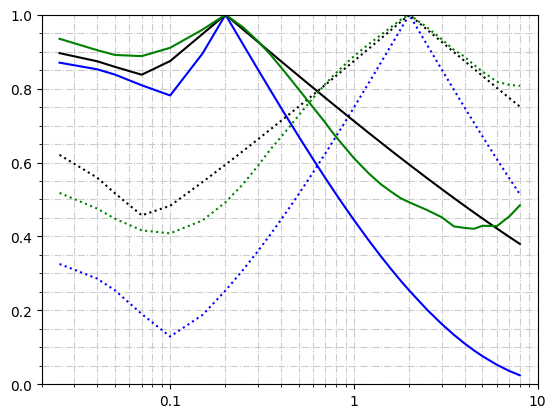

In [186]:
# plot the correlation models

fig, ax = plt.subplots()

models = {"BJ08": bj08,
          "ESHM20": eshm20,
          "CG26": cg26.loc[:, idx[:, "SA", :]]}

model_colours = {"BJ08": "b",
                 "ESHM20": "k", 
                 "CG26": "g"}

period_lines = {0.2: "-",
                2.0: ":"}

# BJ08
for model in models.keys():
    for period in period_lines.keys():
        ax.semilogx(im_periods, models[model].loc[( "rotD50", "SA", period), :],
                    color=model_colours[model], ls=period_lines[period])

ax.grid(True, which="both", ls="-.", color="0.8")
ax.minorticks_on()
ax.set_xlim(0.02, 10)
ax.set_ylim(0, 1.0)
formatter = ticker.FuncFormatter(custom_log_formatter)
ax.xaxis.set_major_formatter(formatter)